In [49]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashishsaxena2209/animal-image-datasetdog-cat-and-panda")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animal-image-datasetdog-cat-and-panda


In [50]:
!pip install opencv-python-headless
import os
import shutil
import cv2
import numpy as np
import torch
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from random import shuffle, sample

In [51]:
categories = ['dogs', 'cats', 'panda']
source_base = '/bin/input/animal-image-datasetdog-cat-and-panda/animals'
target_base = '/bin/input/animal-image-datasetdog-cat-and-panda/images'

def copy_images(source_dir, target_dir, num_images=1000):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    all_files = os.listdir(source_dir)
    shuffle(all_files)

    for file in all_files[:num_images]:
        src_path = os.path.join(source_dir, file)
        dst_path = os.path.join(target_dir, file)
        shutil.copy(src_path, dst_path)

# Copy 1000 images per category
for category in categories:
    source_dir = os.path.join(source_base, category)
    target_dir = os.path.join(target_base, category)
    copy_images(source_dir, target_dir)

In [52]:
IMG_SIZE = 64

def enhanced_preprocessing(img_path):
    try:
        img = cv2.imread(img_path)
        if img is None:
            return None

        # Convert to grayscale with histogram equalization
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.equalizeHist(gray)

        # Noise reduction and resize
        gray = cv2.GaussianBlur(gray, (3, 3), 0)
        resized = cv2.resize(gray, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)

        # Normalize and flatten
        normalized = resized / 255.0
        return normalized.flatten()
    except:
        return None

X_list, y_list = [], []
for label, cls in enumerate(categories):
    cls_path = os.path.join(target_base, cls)
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        processed = enhanced_preprocessing(img_path)
        if processed is not None:
            X_list.append(processed)
            y_list.append(label)

In [53]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_np = pca.fit_transform(np.array(X_list))
y_np = np.array(y_list)

print(f"Reduced dimensions from {len(X_list[0])} to {X_np.shape[1]}")

Reduced dimensions from 4096 to 475


In [54]:
k_values = range(1, 16)
acc_l1, acc_l2 = [], []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for k in k_values:
    fold_l1, fold_l2 = [], []

    for train_idx, test_idx in kf.split(X_np):
        X_train, X_test = X_np[train_idx], X_np[test_idx]
        y_train, y_test = y_np[train_idx], y_np[test_idx]

        # Manhattan (L1)
        model_l1 = KNeighborsClassifier(n_neighbors=k, metric='manhattan', weights='distance')
        model_l1.fit(X_train, y_train)
        fold_l1.append(accuracy_score(y_test, model_l1.predict(X_test)))

        # Euclidean (L2)
        model_l2 = KNeighborsClassifier(n_neighbors=k, metric='euclidean', weights='distance')
        model_l2.fit(X_train, y_train)
        fold_l2.append(accuracy_score(y_test, model_l2.predict(X_test)))

    # Appending the average accuracy for each k after the inner loop completes
    acc_l1.append(np.mean(fold_l1))
    acc_l2.append(np.mean(fold_l2))

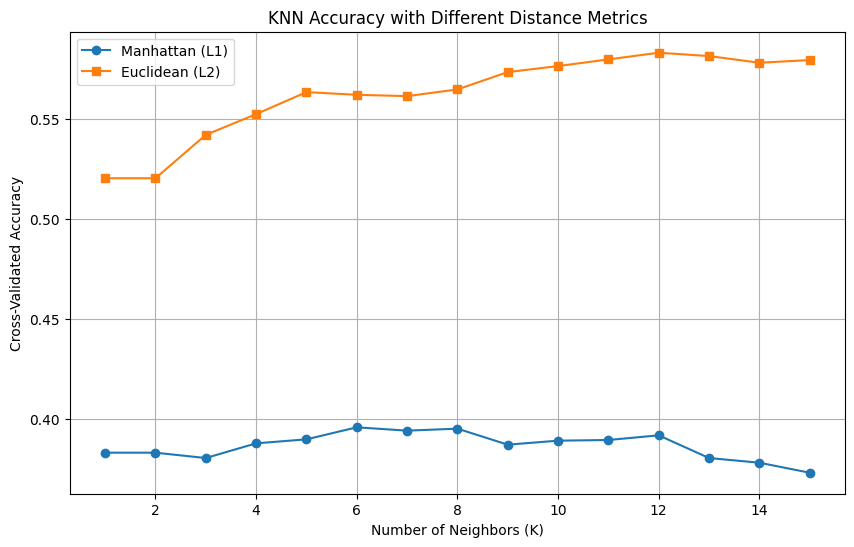

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, acc_l1, 'o-', label='Manhattan (L1)')
plt.plot(k_values, acc_l2, 's-', label='Euclidean (L2)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Accuracy with Different Distance Metrics')
plt.legend()
plt.grid(True)
plt.show()

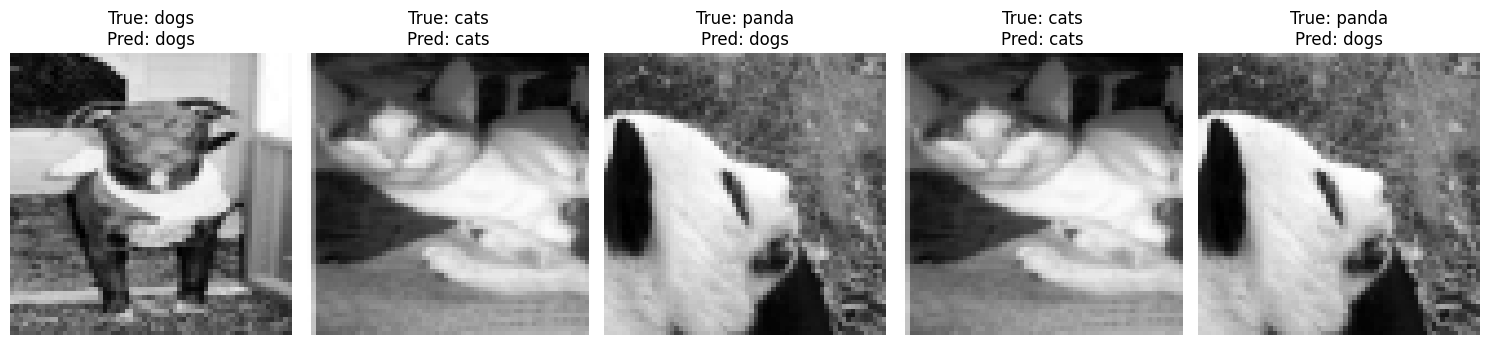

In [56]:
final_knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
final_knn.fit(X_np, y_np)

indices = sample(range(len(dataset)), 5)
samples = []
for index in indices:
    img_path = os.path.join(target_base, categories[y_tensor[index].item()], os.listdir(os.path.join(target_base, categories[y_tensor[index].item()]))[0])
    processed_image = enhanced_preprocessing(img_path)
    if processed_image is not None:
        samples.append(processed_image)

samples = np.array(samples)
labels = y_tensor[indices]

# Apply PCA transformation to the samples before prediction
samples_pca = pca.transform(samples)

preds = final_knn.predict(samples_pca)

plt.figure(figsize=(15, 4))
for i in range(5):
    # Reshape using the original IMG_SIZE
    img = samples[i].reshape(IMG_SIZE, IMG_SIZE)
    true_cls = categories[labels[i].item()]
    pred_cls = categories[preds[i]]
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_cls}\nPred: {pred_cls}")
    plt.axis('off')

plt.tight_layout()
plt.show()